In [9]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

def parse_annotation(xml_file, target_size=(224, 224)):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for obj in root.iter('object'):
        xmlbox = obj.find('bndbox')
        x_min = int(xmlbox.find('xmin').text)
        y_min = int(xmlbox.find('ymin').text)
        x_max = int(xmlbox.find('xmax').text)
        y_max = int(xmlbox.find('ymax').text)
        # Resize bounding box coordinates
        x_min_resized = (x_min / width) * target_size[0]
        y_min_resized = (y_min / height) * target_size[1]
        x_max_resized = (x_max / width) * target_size[0]
        y_max_resized = (y_max / height) * target_size[1]
        return filename, (x_min_resized, y_min_resized, x_max_resized, y_max_resized)

def load_data(image_directory, annotations_directory, target_size=(224, 224)):
    images = []
    boxes = []

    for xml_file in os.listdir(annotations_directory):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_directory, xml_file)
            filename, bbox_resized = parse_annotation(xml_path)

            img_path = os.path.join(image_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)  # Resize image to ensure consistency

            images.append(img)
            boxes.append(bbox_resized)

    return np.array(images), np.array(boxes)

# Paths to your dataset
image_directory = 'archive/images'
annotations_directory = 'archive/annotations'

images, boxes = load_data(image_directory, annotations_directory)

In [10]:
# import os
# import xml.etree.ElementTree as ET
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# def parse_annotation(xml_file):
#     tree = ET.parse(xml_file)
#     root = tree.getroot()
#     filename = root.find('filename').text
#     for obj in root.iter('object'):
#         xmlbox = obj.find('bndbox')
#         x_min = int(xmlbox.find('xmin').text)
#         y_min = int(xmlbox.find('ymin').text)
#         x_max = int(xmlbox.find('xmax').text)
#         y_max = int(xmlbox.find('ymax').text)
#         return filename, (x_min, y_min, x_max, y_max)

# def load_data(image_directory, annotations_directory, target_size=(224, 224)):
#     images = []
#     boxes = []

#     for xml_file in os.listdir(annotations_directory):
#         if xml_file.endswith('.xml'):
#             xml_path = os.path.join(annotations_directory, xml_file)
#             filename, bbox = parse_annotation(xml_path)

#             img_path = os.path.join(image_directory, filename)
#             img = cv2.imread(img_path)
#             img = cv2.resize(img, target_size)  # Resize image to ensure consistency

#             # Ensure bounding box is normalized and in the correct shape
#             h, w, _ = img.shape
#             normalized_bbox = [
#                 bbox[0] / w, 
#                 bbox[1] / h, 
#                 bbox[2] / w, 
#                 bbox[3] / h
#             ]
            
#             images.append(img)
#             boxes.append(normalized_bbox)

#     return np.array(images), np.array(boxes)

# # Paths to your dataset
# image_directory = 'archive/images'
# annotations_directory = 'archive/annotations'

# images, boxes = load_data(image_directory, annotations_directory)
print(images[:5])
print(boxes[:5])


[[[[172 178 174]
   [172 179 175]
   [172 178 175]
   ...
   [100 105 104]
   [111 116 112]
   [110 116 112]]

  [[170 176 172]
   [169 176 173]
   [169 176 173]
   ...
   [102 107 106]
   [110 115 112]
   [111 116 113]]

  [[169 176 172]
   [166 175 171]
   [170 177 174]
   ...
   [105 110 108]
   [110 115 111]
   [113 117 114]]

  ...

  [[ 43  42  38]
   [ 45  44  42]
   [ 43  43  40]
   ...
   [ 64  65  64]
   [ 64  65  64]
   [ 63  65  65]]

  [[ 43  43  40]
   [ 44  44  41]
   [ 44  43  40]
   ...
   [ 61  63  62]
   [ 62  63  63]
   [ 63  65  64]]

  [[ 40  41  37]
   [ 40  41  38]
   [ 38  38  36]
   ...
   [ 62  64  63]
   [ 64  65  64]
   [ 64  65  64]]]


 [[[252 249 251]
   [249 249 254]
   [248 251 255]
   ...
   [120 121 118]
   [227 231 231]
   [243 250 252]]

  [[254 254 249]
   [251 255 252]
   [245 251 251]
   ...
   [ 21  22  19]
   [213 218 217]
   [246 251 252]]

  [[252 255 245]
   [247 254 244]
   [240 247 238]
   ...
   [ 19  19  13]
   [227 231 228]
   [243 248

In [16]:
# ... assuming previous data loading functions are correct ...
X_train, X_test, y_train, y_test = train_test_split(images, boxes, test_size=0.2, random_state=42)

# Define the CNN model for bounding box regression
def create_model(input_shape=(224, 224, 3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4)  # Output layer with 4 nodes for bounding box without activation function
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

model = create_model(input_shape=(224, 224, 3))
model.summary()

# Train the model, making sure that the labels are appropriately scaled
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

# ... continue with predictions and further evaluations ...


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 186624)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [11]:
# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(images, boxes, test_size=0.2, random_state=42)

# # Define the CNN model for bounding box regression
# def create_model(input_shape=(224, 224, 3)):
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(4, activation='sigmoid')  # Output layer with 4 nodes for bounding box
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Adjust the input shape if your preprocessed images have a different size
# model = create_model(input_shape=(224, 224, 3))
# model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [12]:
# # Train the model
# # Note: Depending on the size of your images, you may need to resize them or use batch processing
# model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 12s 1s/step - loss: 17912.1465 - val_loss: 17375.1465
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 17913.2090 - val_loss: 17375.1465
Epoch 3/10
9/9 [==============================] - 9s 981ms/step - loss: 17913.2109 - val_loss: 17375.1465
Epoch 4/10
9/9 [==============================] - 9s 987ms/step - loss: 17913.2109 - val_loss: 17375.1465
Epoch 5/10
9/9 [==============================] - 9s 981ms/step - loss: 17913.2090 - val_loss: 17375.1465
Epoch 6/10
9/9 [==============================] - 9s 970ms/step - loss: 17913.2090 - val_loss: 17375.1465
Epoch 7/10
9/9 [==============================] - 9s 980ms/step - loss: 17913.2109 - val_loss: 17375.1465
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 17913.2109 - val_loss: 17375.1465
Epoch 9/10
9/9 [==============================] - 9s 1s/step - loss: 17913.2090 - val_loss: 17375.1465
Epoch 10/10
9/9 [==============================] - 9s 1s/

In [13]:
# Evaluate the model
# model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 237ms/step - loss: 18202.5020


18202.501953125

3/3 [==============================] - 2s 461ms/step
(21, 158, 64, 196)
(80, 141, 108, 147)


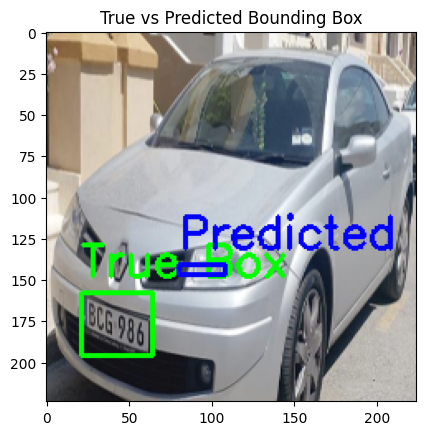

(106, 87, 143, 114)
(107, 80, 142, 114)


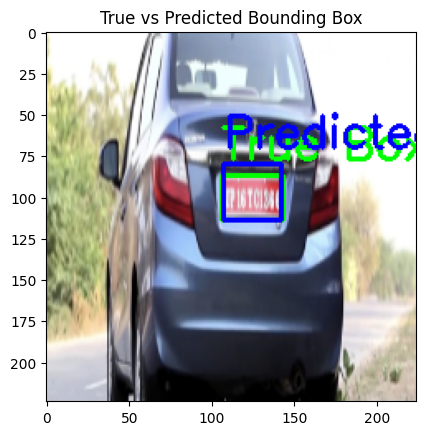

(139, 165, 179, 179)
(142, 158, 173, 172)


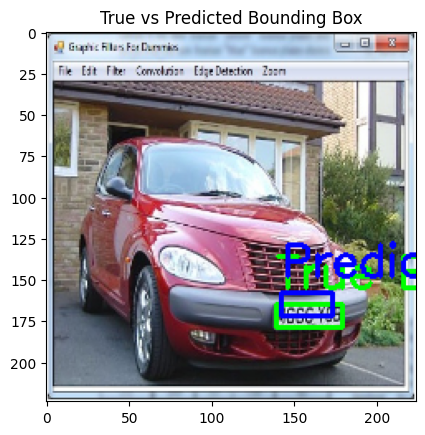

(86, 86, 124, 111)
(68, 110, 117, 128)


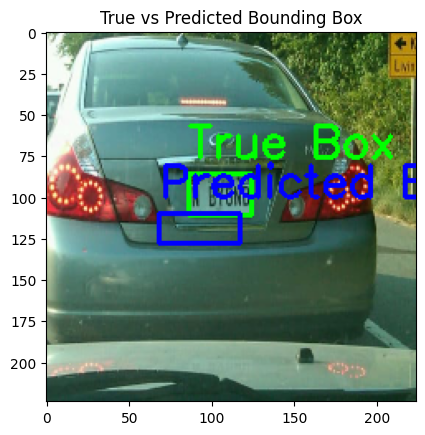

(84, 110, 137, 129)
(93, 109, 133, 116)


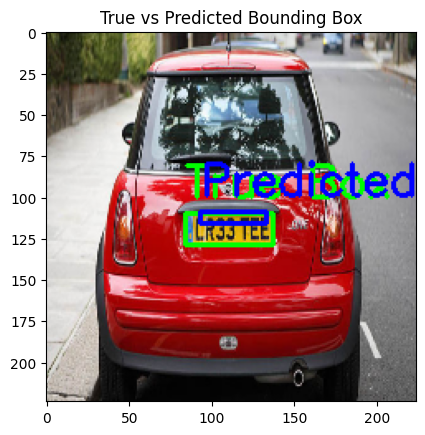

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Predict bounding boxes on the test set
predictions = model.predict(X_test)

def draw_box(img, box, color, label):
    print(box)
    """
    Draw a bounding box on an image with a label at the top-left corner.
    """
    # Draw the bounding box
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
    # Draw the label
    cv2.putText(img, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Adapt the plotting function to work with non-normalized coordinates
def plot_image_with_bbox(img, box, pred_box):
    # Draw the true and predicted boxes
    draw_box(img, (int(box[0]), int(box[1]), int(box[2]), int(box[3])), (0, 255, 0), "True Box")
    draw_box(img, (int(pred_box[0]), int(pred_box[1]), int(pred_box[2]), int(pred_box[3])), (255, 0, 0), "Predicted Box")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('True vs Predicted Bounding Box')
    plt.show()

# Plot the bounding boxes on a test image
for i in range(5):  # Just plotting the first 5 images as an example
    plot_image_with_bbox(X_test[i], y_test[i], predictions[i])